In [42]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [43]:
# Data loading
path = r'../data/processed/data_processed_v2_NoAcum_Total.csv'
alzheimer_df = pd.read_csv(path)

print(alzheimer_df.info())
alzheimer_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18304 entries, 0 to 18303
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         18304 non-null  int64  
 1   Week         18304 non-null  int64  
 2   Date         18304 non-null  object 
 3   Entity       18304 non-null  object 
 4   Epi_Year     18304 non-null  int64  
 5   total_cases  18304 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 858.1+ KB
None


,Year,Week,Date,Entity,Epi_Year,total_cases
0,2014,2,2014-01-13,Aguascalientes,2014,0.0
1,2014,3,2014-01-20,Aguascalientes,2014,0.0
2,2014,4,2014-01-27,Aguascalientes,2014,0.0
3,2014,5,2014-02-03,Aguascalientes,2014,0.0
4,2014,6,2014-02-10,Aguascalientes,2014,0.0


In [44]:
df_national = alzheimer_df.groupby(['Year', 'Week', 'Date'], as_index=False)['total_cases'].sum()

print(df_national.info())
df_national.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         572 non-null    int64  
 1   Week         572 non-null    int64  
 2   Date         572 non-null    object 
 3   total_cases  572 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 18.0+ KB
None


,Year,Week,Date,total_cases
0,2014,2,2014-01-13,4.0
1,2014,3,2014-01-20,29.0
2,2014,4,2014-01-27,47.0
3,2014,5,2014-02-03,36.0
4,2014,6,2014-02-10,42.0


In [45]:
# DataFrame with columns: 'Date' (date), 'total_cases' (target)

df_prophet = df_national.rename(columns={'Date':'ds', 'total_cases':'y'}).copy()
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_prophet = df_prophet.sort_values('ds')

df_prophet.head()

,Year,Week,ds,y
0,2014,2,2014-01-13,4.0
1,2014,3,2014-01-20,29.0
2,2014,4,2014-01-27,47.0
3,2014,5,2014-02-03,36.0
4,2014,6,2014-02-10,42.0


In [46]:
print(df_prophet['ds'].duplicated().sum())  # It has to be 0

2


In [47]:
# Finding duplicates for inspection
dupes = df_prophet[df_prophet['ds'].duplicated(keep=False)]
print(dupes)

     Year  Week         ds     y
52   2015     1 2015-01-05  18.0
51   2014    53 2015-01-05  14.0
365  2021     1 2021-01-04  13.0
364  2020    53 2021-01-04  25.0


In [48]:
# Fixing duplicates by aggregating
df_prophet_fixed = df_prophet.groupby('ds', as_index=False)['y'].sum()
print(df_prophet_fixed['ds'].duplicated().sum())

0


In [49]:
# 80/20 split, last 20% as test set
split_idx = int(len(df_prophet_fixed)*0.8)
train_df = df_prophet_fixed[:split_idx].copy()
test_df  = df_prophet_fixed[split_idx:].copy()


In [50]:
# Prophet model fitting
model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
model.fit(train_df)

22:55:13 - cmdstanpy - INFO - Chain [1] start processing
22:55:13 - cmdstanpy - INFO - Chain [1] done processing


In [51]:
# Generate future dates for prediction (using test set dates)
# Ensures Prophet predicts exactly for the weeks we want to evaluate.
future = pd.DataFrame({'ds': test_df['ds'].values})

print(future['ds'].tail())
print(test_df['ds'].tail())


109   2024-11-25
110   2024-12-02
111   2024-12-09
112   2024-12-16
113   2024-12-23
Name: ds, dtype: datetime64[ns]
565   2024-11-25
566   2024-12-02
567   2024-12-09
568   2024-12-16
569   2024-12-23
Name: ds, dtype: datetime64[ns]


In [52]:
# Predict total cases for the future dates
forecast = model.predict(future)

# Align predictions and actuals for evaluation (1:1 merge)
eval_df = test_df.merge(forecast[['ds', 'yhat']], on='ds')

In [53]:
# Evaluation Metrics

# Extract vectors for ground-truth and forecasts
y_true = eval_df['y'].values
y_pred = eval_df['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred) * 100

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE:  14.01
RMSE: 19.60
MAPE: 33.17%


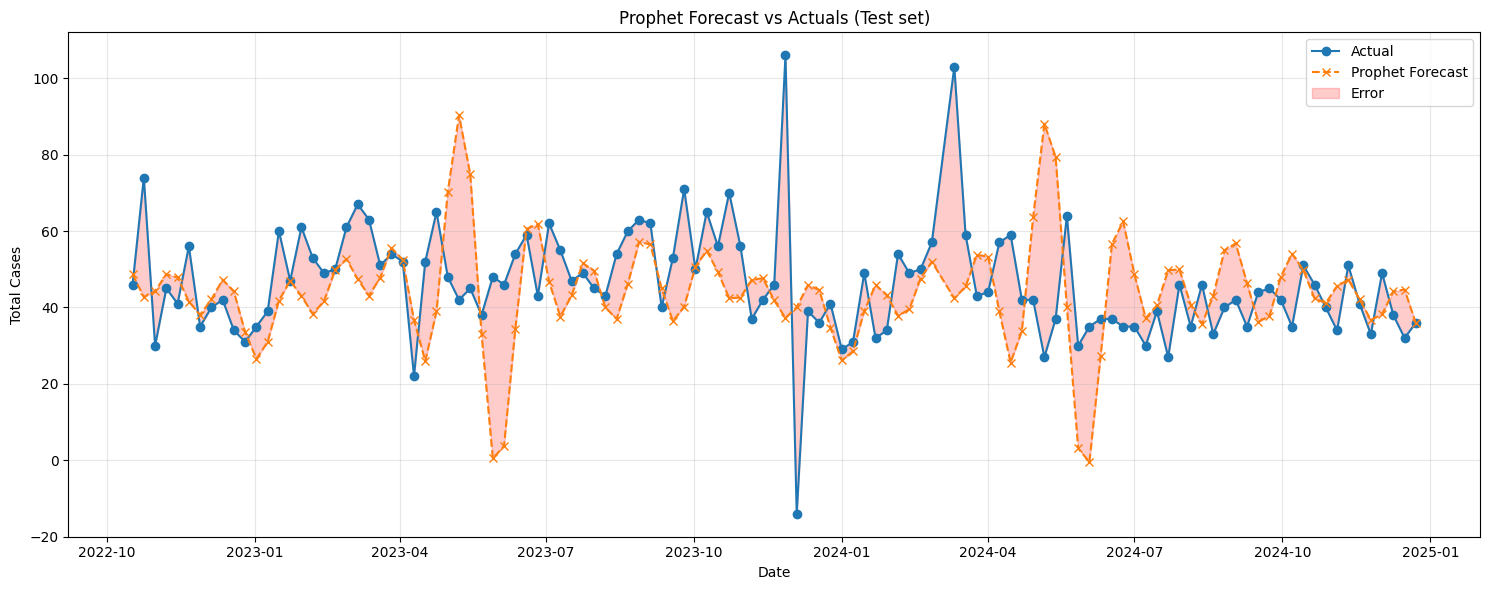

In [54]:
# Visualization – Prophet Forecast vs Actuals

plt.figure(figsize=(15,6))
plt.plot(eval_df['ds'], eval_df['y'], 'o-', label='Actual')
plt.plot(eval_df['ds'], eval_df['yhat'], 'x--', label='Prophet Forecast')
plt.fill_between(eval_df['ds'], eval_df['y'], eval_df['yhat'], alpha=0.2, color='red', label='Error')
plt.xlabel('Date'); plt.ylabel('Total Cases')
plt.title('Prophet Forecast vs Actuals (Test set)')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


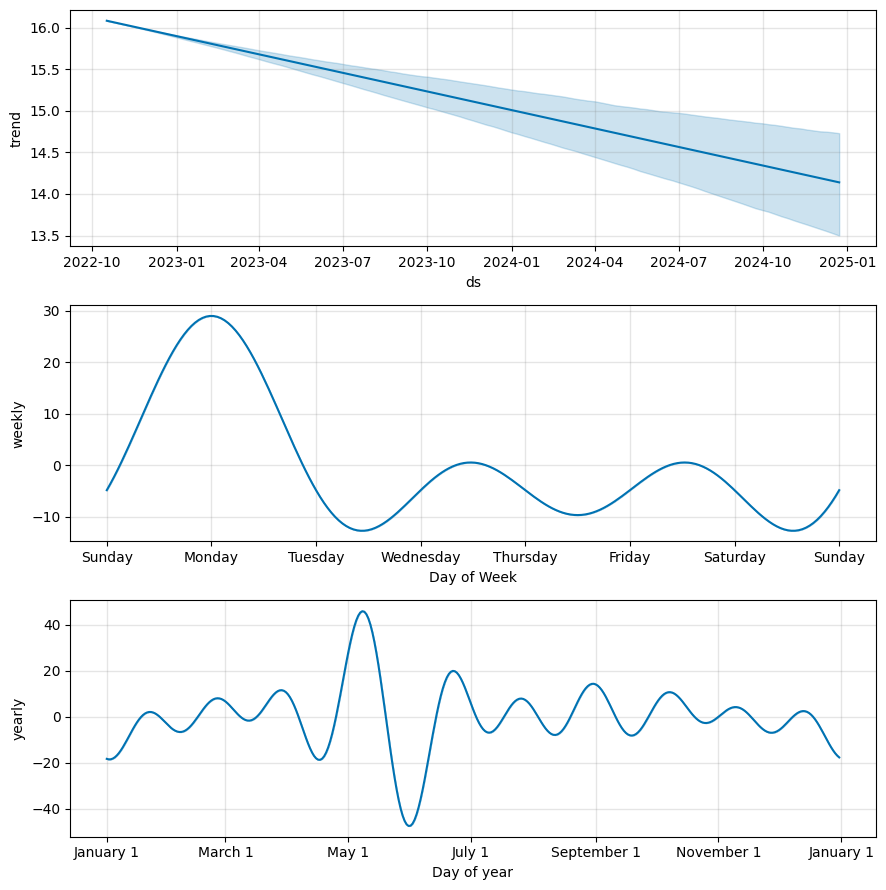

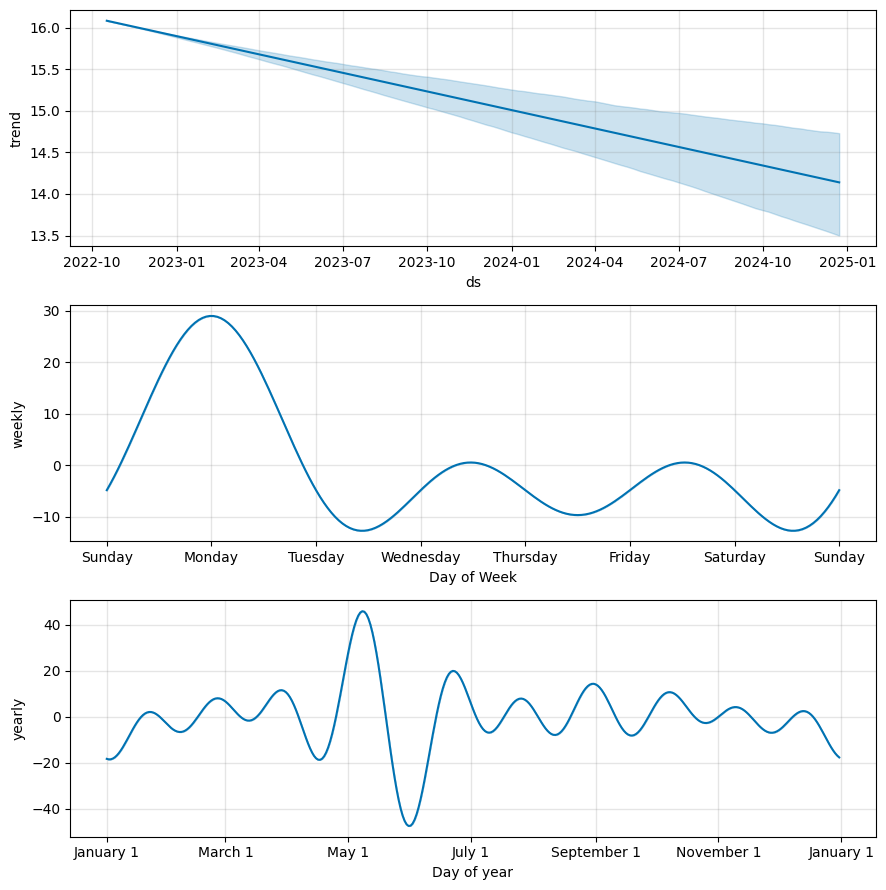

In [55]:
model.plot_components(forecast)